# Jigsaw - Agile Community Rules Classification

> Using AI models to help moderators uphold community-specific norms.

Competition: https://www.kaggle.com/competitions/jigsaw-agile-community-rules

In [4]:
import kagglehub
import numpy as np
import pandas as pd
import transformers
import torch

from pathlib import Path

COMPETITION_HANDLE = "jigsaw-agile-community-rules"
MODEL_HANDLE = "google/gemma-3/transformers/gemma-3-1b-it"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


## Setup

### Via Kaggle's UI

*Note that the UI might have changed since `2025-09-02`.*

The kaggle instance already has access to the competion data.

For the language models, we need GPU acceleration!

`Settings > Accelerator > GPU T4 x2`

Open the notebook sidetab:

`View > Show Sidebar`

You can add data and models via the `+ Add Input` button.
Search for Gemma 3 and add the 1b-it variant for the `transformers` Framework.
It should show up under: `/kaggle/input/gemma-3/transformers/gemma-3-1b-it/1`
You can also try other models, but be aware, that the kaggle instance has limited GPU memory.
Everything above `7b` will probably run into memory issues, unless the model is quantized.

### Via KaggleHub

Alternatively, we can also use `kagglehub`, allowing us to keep the file paths consistent between kaggle's notebook environment and local execution.
However, we need to provide our login credentials for

1. If you don't have an API token yet, create a new one at: https://www.kaggle.com/settings/account
2. Provide your credentials in `~/.kaggle/kaggle.json` (where `~` is your home directory)

If you are using the devcontainer setup, you can also put your credentials in `.devcontainer/kaggle.env`.
This defines the environment variables `KAGGLE_USERNAME` and `KAGGLE_KEY` for `kagglehub` to use.

See [kagglehubs README](https://github.com/Kaggle/kagglehub) for more information.

Alternatively, you can run this cell to login:

In [5]:
try:
    # already logged in?
    whoami = kagglehub.whoami()
except kagglehub.exceptions.UnauthenticatedError:
    # otherwise login
    kagglehub.login()

Kaggle credentials successfully validated.


## Downloading Data and Models

In [6]:
DATA_PATH = Path(kagglehub.competition_download(COMPETITION_HANDLE))
print(DATA_PATH)

/root/.cache/kagglehub/competitions/jigsaw-agile-community-rules


In [7]:
import kagglehub

LLM_PATH = Path(kagglehub.model_download(MODEL_HANDLE))
print(LLM_PATH)

/root/.cache/kagglehub/models/google/gemma-3/transformers/gemma-3-1b-it/1


## A first look at the Data

In [8]:
# check data files
for dirname, _, filenames in DATA_PATH.walk():
    for filename in filenames:
        print(dirname / filename)

/root/.cache/kagglehub/competitions/jigsaw-agile-community-rules/sample_submission.csv
/root/.cache/kagglehub/competitions/jigsaw-agile-community-rules/test.csv
/root/.cache/kagglehub/competitions/jigsaw-agile-community-rules/train.csv


In [9]:
train_df = pd.read_csv(DATA_PATH / "train.csv")
test_df = pd.read_csv(DATA_PATH / "test.csv")
sample_df = pd.read_csv(DATA_PATH / "sample_submission.csv")

In [10]:
train_df.head()

,row_id,body,rule,subreddit,positive_example_1,positive_example_2,negative_example_1,negative_example_2,rule_violation
0,0,Banks don't want you to know this! Click here ...,"No Advertising: Spam, referral links, unsolici...",Futurology,If you could tell your younger self something ...,hunt for lady for jack off in neighbourhood ht...,Watch Golden Globe Awards 2017 Live Online in ...,"DOUBLE CEE x BANDS EPPS - ""BIRDS""\n\nDOWNLOAD/...",0
1,1,SD Stream [ ENG Link 1] (http://www.sportsstre...,"No Advertising: Spam, referral links, unsolici...",soccerstreams,[I wanna kiss you all over! Stunning!](http://...,LOLGA.COM is One of the First Professional Onl...,#Rapper \n🚨Straight Outta Cross Keys SC 🚨YouTu...,[15 Amazing Hidden Features Of Google Search Y...,0
2,2,Lol. Try appealing the ban and say you won't d...,No legal advice: Do not offer or request legal...,pcmasterrace,Don't break up with him or call the cops. If ...,It'll be dismissed: https://en.wikipedia.org/w...,Where is there a site that still works where y...,Because this statement of his is true. It isn'...,1
3,3,she will come your home open her legs with an...,"No Advertising: Spam, referral links, unsolici...",sex,Selling Tyrande codes for 3€ to paypal. PM. \n...,tight pussy watch for your cock get her at thi...,NSFW(obviously) http://spankbang.com/iy3u/vide...,Good News ::Download WhatsApp 2.16.230 APK for...,1
4,4,code free tyrande --->>> [Imgur](http://i.imgu...,"No Advertising: Spam, referral links, unsolici...",hearthstone,wow!! amazing reminds me of the old days.Well...,seek for lady for sex in around http://p77.pl/...,must be watch movie https://sites.google.com/s...,We're streaming Pokemon Veitnamese Crystal RIG...,1


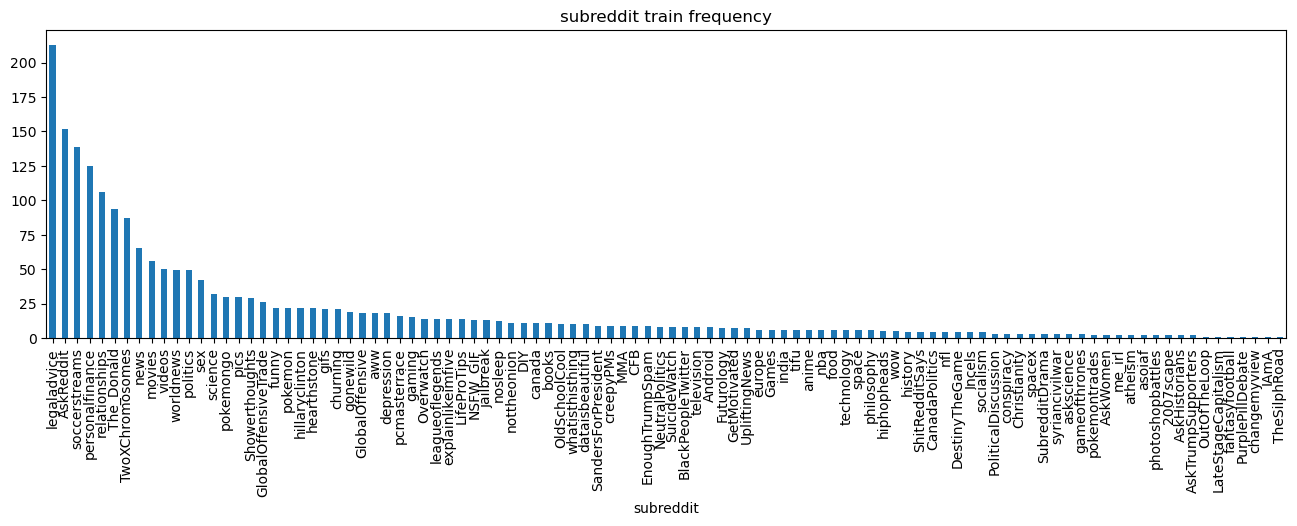

In [11]:
train_df["subreddit"].value_counts().plot.bar(figsize=(16,4), title="subreddit train frequency");


<Axes: title={'center': 'rule violations per subreddit'}, xlabel='subreddit'>

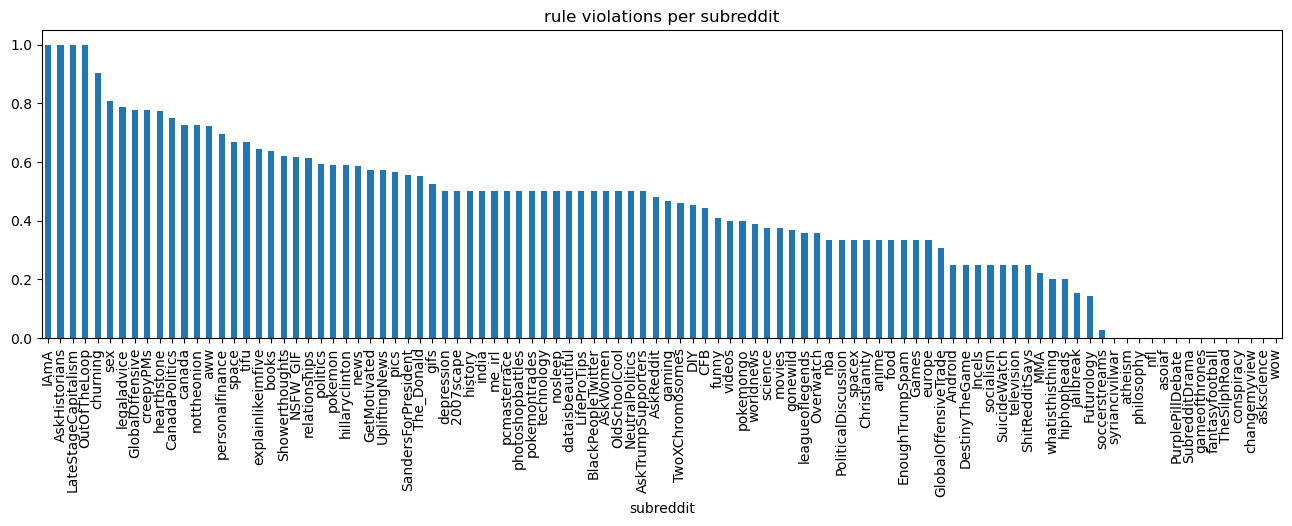

In [12]:
train_df.groupby("subreddit")["rule_violation"].mean().sort_values(ascending=False).plot.bar(figsize=(16,4), title="rule violations per subreddit")

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier

# need to onehot encode subreddit for DecisionTreeClassifier
x = pd.get_dummies(train_df["subreddit"])
y = train_df["rule_violation"]

cross_val_score(DecisionTreeClassifier(), x, y, cv=5)

array([0.59014778, 0.60453649])

## Approach: LLM Few-Shot Prompting

In [19]:
from transformers import AutoModelForCausalLM, AutoTokenizer

llm = AutoModelForCausalLM.from_pretrained(LLM_PATH)
tokenizer = AutoTokenizer.from_pretrained(LLM_PATH)

llm.to(DEVICE)

Gemma3ForCausalLM(
  (model): Gemma3TextModel(
    (embed_tokens): Gemma3TextScaledWordEmbedding(262144, 1152, padding_idx=0)
    (layers): ModuleList(
      (0-25): 26 x Gemma3DecoderLayer(
        (self_attn): Gemma3Attention(
          (q_proj): Linear(in_features=1152, out_features=1024, bias=False)
          (k_proj): Linear(in_features=1152, out_features=256, bias=False)
          (v_proj): Linear(in_features=1152, out_features=256, bias=False)
          (o_proj): Linear(in_features=1024, out_features=1152, bias=False)
          (q_norm): Gemma3RMSNorm((256,), eps=1e-06)
          (k_norm): Gemma3RMSNorm((256,), eps=1e-06)
        )
        (mlp): Gemma3MLP(
          (gate_proj): Linear(in_features=1152, out_features=6912, bias=False)
          (up_proj): Linear(in_features=1152, out_features=6912, bias=False)
          (down_proj): Linear(in_features=6912, out_features=1152, bias=False)
          (act_fn): PytorchGELUTanh()
        )
        (input_layernorm): Gemma3RMSNorm((11

In [20]:
# try out the llm
prompt = input("your prompt for the llm >")

if prompt == "":
    prompt = "Hi, how are you?"

In [21]:
# apply tokenizer
input_ids = tokenizer.encode(prompt, return_tensors="pt")
input_ids

tensor([[     2,   6294,    611,   1133,  70383, 236765,  69123, 236881]])

In [22]:
output_ids = llm.generate(input_ids.to(DEVICE))
output_ids

/opt/conda/lib/python3.12/site-packages/torch/_inductor/compile_fx.py:167: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(


tensor([[     2,   6294,    611,   1133,  70383, 236765,  69123, 236881,    108,
         236769,  10784, 236786,   3771, 236768,    108,   2859,    611,  19398,
            623,   3771,   2098,   1299,   5091,   3442,    786,   3217, 236761,
            108]], device='cuda:0')

In [23]:
tokenizer.batch_decode(output_ids)

['<bos>Do you like Bratwurst?\n\n(Yes/No)\n\nIf you answered "No," then please tell me why.\n\n']

In [24]:
# you can use a pipeline object to simplify the prompting
from transformers.pipelines import pipeline

pipe = pipeline("text-generation", model=LLM_PATH)

Device set to use cuda:0


In [28]:
# however, we want the llm to answer our question instead of elaborating on it
# first of all, we need an instruction tuned (it) model
# then, we need to apply the chat template
chat = [
    { "role": "user", "content": prompt},
]

messages = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)

pipe(messages, max_new_tokens=50, return_full_text=False)

[{'generated_text': 'As an AI, I don’t have taste buds or the ability to eat, so I can’t *like* anything! 😊 \n\nHowever, I can tell you that Bratwurst is a *very* popular and beloved food in'}]

In [35]:
def make_message(tokenizer, template, **kwargs):
    content = template.format(**kwargs)

    chat = [
        { "role": "user", "content": content},
    ]

    messages = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)

    return messages 


In [47]:
template_few_shot = """
You are a very serious and hard-working reddit mod from the {subreddit} subreddit and need to flag comments if they violate the following rule:
{rule}

Answer only with 'True', if they violate the rule, otherwise answer only with 'False'. Omit everything else.
Here are some examples to get you started:

# Example 1

Comment: {positive_example_1}
Output: True

# Example 2

Comment: {positive_example_2}
Output: True

# Example 3

Comment: {negative_example_1}
Output: False

# Example 4

Comment: {negative_example_2}
Output: False

# Test

Now it's your turn!

Comment: {body}
Output:
"""

In [69]:
from tqdm.notebook import tqdm

def predict_rows(df: pd.DataFrame, tokenizer, template, pipe):
    outputs = []
    total = len(df)
    for row_id, row in tqdm(df.iterrows(), total=total):
        messages = make_message(tokenizer, template, **row)
        output = pipe(messages, max_new_tokens=1, return_full_text=False)
        output = output[0]["generated_text"]
        outputs.append(output)
    return outputs

In [70]:
y_hat = predict_rows(test_df, tokenizer, template_few_shot, pipe)

  0%|          | 0/10 [00:00<?, ?it/s]

In [72]:
#val_df = train_df.sample(100, random_state=19)
val_df = train_df.copy()

x_df = val_df.drop(columns="rule_violation")
y_df = val_df["rule_violation"]

y_val_pred = predict_rows(x_df, tokenizer, template_few_shot, pipe)

  0%|          | 0/2029 [00:00<?, ?it/s]

<Axes: >

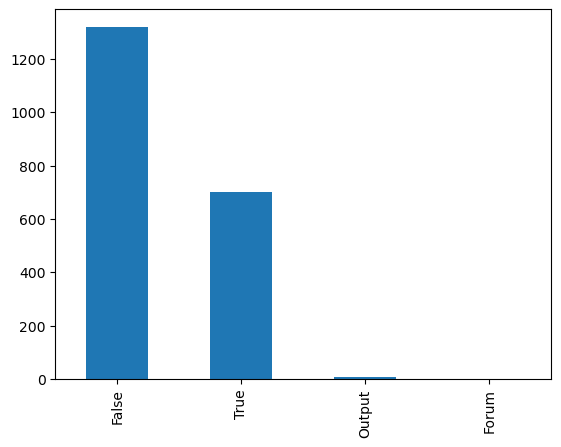

In [75]:
pd.Series(y_val_pred).value_counts().plot.bar()

In [77]:
y_val = y_df.astype(bool).astype(str)

In [80]:
(y_val == y_val_pred).mean()

np.float64(0.5012321340561853)